# Simple Bayesian Linear Regression with TensorFlow Probability

2020-10-06

Dr. Juan Camilo Orduz

https://juanitorduz.github.io/tfp_lm/



In this post we show how to fit a simple linear regression model using TensorFlow Probability by replicating the first example on the getting started guide for PyMC3. We are going to use Auto-Batched Joint Distributions as they simplify the model specification considerably. Moreover, there is a great resource to get deeper into this type of distribution: Auto-Batched Joint Distributions: A Gentle Tutorial, which I strongly recommend (see this post to get a brief introduction on TensorFlow probability distributions). In addition the tutorial: Bayesian Modeling with Joint Distribution is also a great reference to get started with linear models in TensorFlow Probability.


Oct 10, 2021

This is a good(!) tutorial. Everything works.

## Prepare Notebook



In [1]:
import numpy as np
import pandas as pd
from tqdm import trange

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

TnesorFlow version: 2.4.1
TnesorFlow Probability version: 0.12.1


2021-10-12 06:29:54.470707: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Define Model

Our model is
- y ∼ N(μ,σ^2)
- μ = α + β_0 x_0 + β_1 x_1

with the priors
- α ∼ N(0,100)
- β_i ∼ N(0,100)
- σ ∼ |N(0,1)|


In [2]:
xname="sm_0.67"; yname="halo_mass"
xname="sm_1.0"; yname="halo_mass"; x2name="central_sm"

gal_df = pd.read_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("Data/cluster_data_0.3-0.6.csv")
x=cluster_data[xname]; 
y=cluster_data[yname];
x2=cluster_data[x2name]

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000,  contamination="auto", random_state=0)

# split into train and test sets

X=np.vstack([x,x2]).transpose()
X_train, X_test,  y_train, y_test = train_test_split(X, y, train_size=0.67)
print("train:  ",X_train.shape, y_train.shape," test:  ",  X_test.shape, y_test.shape)

 
unit_df =pd.DataFrame(data={xname:X_train[:,0], x2name:X_train[:,1], yname:y_train})

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(unit_df)
print("X_t train shape",X_t.shape)

# Remove outliers.
detector = IsolationForest(n_estimators=1000,  contamination=0.15, random_state=0)
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]
unit_df =pd.DataFrame(data={xname:X_t[:,0], x2name:X_t[:,1], yname:X_t[:,2]})
print("X_t trainshape  after outlier rejection:  ",X_t.shape)

X_t = scaler.inverse_transform(unit_df)
inv_df=pd.DataFrame(data={xname:X_t[:,0], x2name:X_t[:,1], yname:X_t[:,2]})
xc=X_t[:,0]
yc=X_t[:,1]

train:   (192, 2) (192,)  test:   (95, 2) (95,)
X_t train shape (192, 3)
X_t trainshape  after outlier rejection:   (163, 3)


In order to define the model in TensorFlow Probability let us first convert our input into tf tensors.

In [3]:
# Set seed.
tf.random.set_seed(42)
# Set tensor numeric type.
dtype = 'float32'

# all the data
x = np.vstack([cluster_data[xname],cluster_data[x2name]]).transpose()
x = tf.convert_to_tensor(x, dtype=dtype)

y = tf.convert_to_tensor(cluster_data[yname], dtype=dtype)
y = tf.reshape(y, (-1, 1))

# Just the train data
x = np.vstack([inv_df[xname],inv_df[x2name]]).transpose()
x = tf.convert_to_tensor(x, dtype=dtype)

y = tf.convert_to_tensor(inv_df[yname], dtype=dtype)
y = tf.reshape(y, (-1, 1))

print("x shape: {}, y shape: {}".format(x.shape,y.shape))

x shape: (163, 2), y shape: (163, 1)


2021-10-12 06:30:01.791939: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 06:30:01.792316: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Define the model

Next, we define our model distribution using Auto-Batched Joint Distributions. Note how similar the model specification is to the mathematical definition.   (See first part of blog post, not present in this notebook.)

In [4]:
jds_ab = tfd.JointDistributionNamedAutoBatched(dict(

    sigma=tfd.HalfNormal(scale=[tf.cast(1.0, dtype)]),

    alpha=tfd.Normal(
        #loc=[tf.cast(0.0, dtype)], 
        loc=[tf.cast(2.5, dtype)], 
        scale=[tf.cast(10.0, dtype)]
    ),

    beta=tfd.Normal(
        #loc=[[tf.cast(0.0, dtype)], [tf.cast(0.0, dtype)]], 
        loc=[[tf.cast(0.5, dtype)], [tf.cast(0.35, dtype)]],
        scale=[[tf.cast(10.0, dtype)], [tf.cast(10.0, dtype)]]
    ),

    y=lambda beta, alpha, sigma: 
        tfd.Normal(
            loc=tf.linalg.matmul(x, beta) + alpha, 
            scale=sigma
        ) 
))


### Prior Simulations

Next, before fitting the model, we want to generate predictions with the prior distributions.

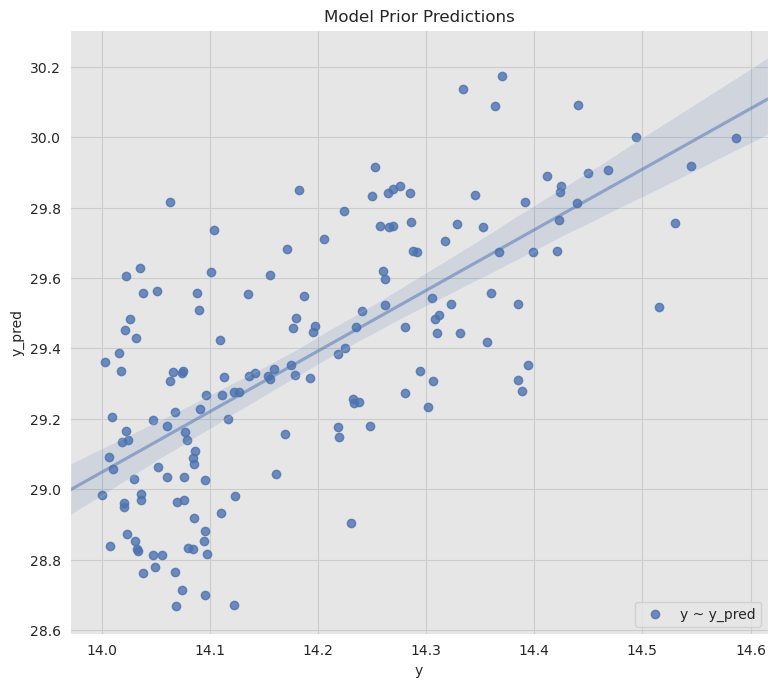

In [6]:
# Sample from the prior.
prior_samples = jds_ab.sample(500)['y']

prior_samples = tf.squeeze(prior_samples)
prior_mean = tf.math.reduce_mean(prior_samples, axis=0).numpy()
prior_std = tf.math.reduce_std(prior_samples, axis=0).numpy()

fig, ax = plt.subplots(figsize=(9, 8)) 
if 1==0 :
    ax.errorbar(
        x=tf.squeeze(y).numpy(), 
        y=prior_mean, 
        yerr=2*prior_std,
        fmt='o',
        ecolor=sns_c[9],
        capsize=2,
        label='predictions + credible intervals',
    )
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=prior_mean, 
    color=sns_c[0], 
    #scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
#print(tf.squeeze(y).numpy())
#print(prior_mean)
      
#ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Prior Predictions', xlabel='y', ylabel='y_pred');

We see that the priors are very flat and the range for predictions is very wide.

Remark: In many applications one would like to restrict the priors a little bit more to encode domain knowledge information.

### Fit Model

Now we fit the model using Hamiltonian Monte Carlo (see this post for another example).

First, we need to define the target function, which in this case is simply the log-probability.

In [7]:
#def target_log_prob_fn(beta=beta, alpha=alpha, sigma=sigma):
def target_log_prob_fn(beta, alpha, sigma):
    return jds_ab.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=y)

# Size of each chain.
num_results = int(3e4)
# Burn-in steps.
num_burnin_steps = int(2e5)
#num_burnin_steps = int(2e4)


# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3
  
)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)
# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.convert_to_tensor([[1.0], [1.0]], dtype=dtype),
          tf.convert_to_tensor([1.0], dtype=dtype), 
          tf.convert_to_tensor([1.0], dtype=dtype)
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples

In [ ]:
# Set number of chains. 
num_chains = 10
# Run sampling. 
chains = [run_chain() for i in trange(num_chains)]

print(len(chains[0][0]))

 90%|█████████ | 9/10 [2:07:54<14:02, 842.87s/it]  

Visualize Posterior Distributions

Let us collect and format the chains output for visualization.

Remark: There are many (better) ways to format the output of the sampling. In addition, one could use ArviZ to generate the visualization. For now we just stick to matplotlib and seaborn.

In [9]:
chains_t = list(map(list, zip(*chains)))

chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

In [10]:
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['beta_0', 'beta_1', 'alpha', 'sigma']
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % num_results,
        chain_id=lambda x: (x['sample_id'] / num_results).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

,beta_0,beta_1,alpha,sigma,sample_id,chain_sample_id,chain_id
0,0.513771,0.213867,5.421652,0.094556,0,0,c_1
1,0.518137,0.210135,5.421359,0.092097,1,1,c_1
2,0.518137,0.210135,5.421359,0.092097,2,2,c_1
3,0.518670,0.210263,5.421724,0.093832,3,3,c_1
4,0.518670,0.210263,5.421724,0.093832,4,4,c_1


In [11]:
x.shape

TensorShape([163, 2])

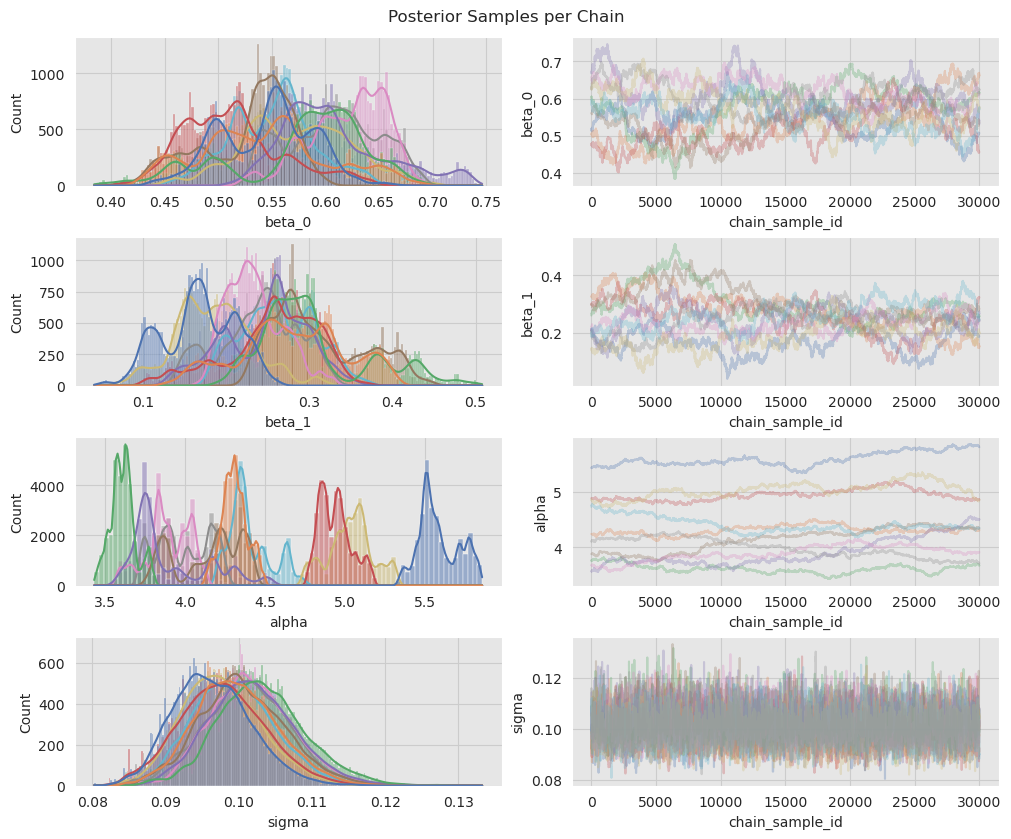

In [12]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    if num_chains < 6 :
        sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    else :
        sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0], legend=False)
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03);

Now we generate the sample plot but with all the chains combined.



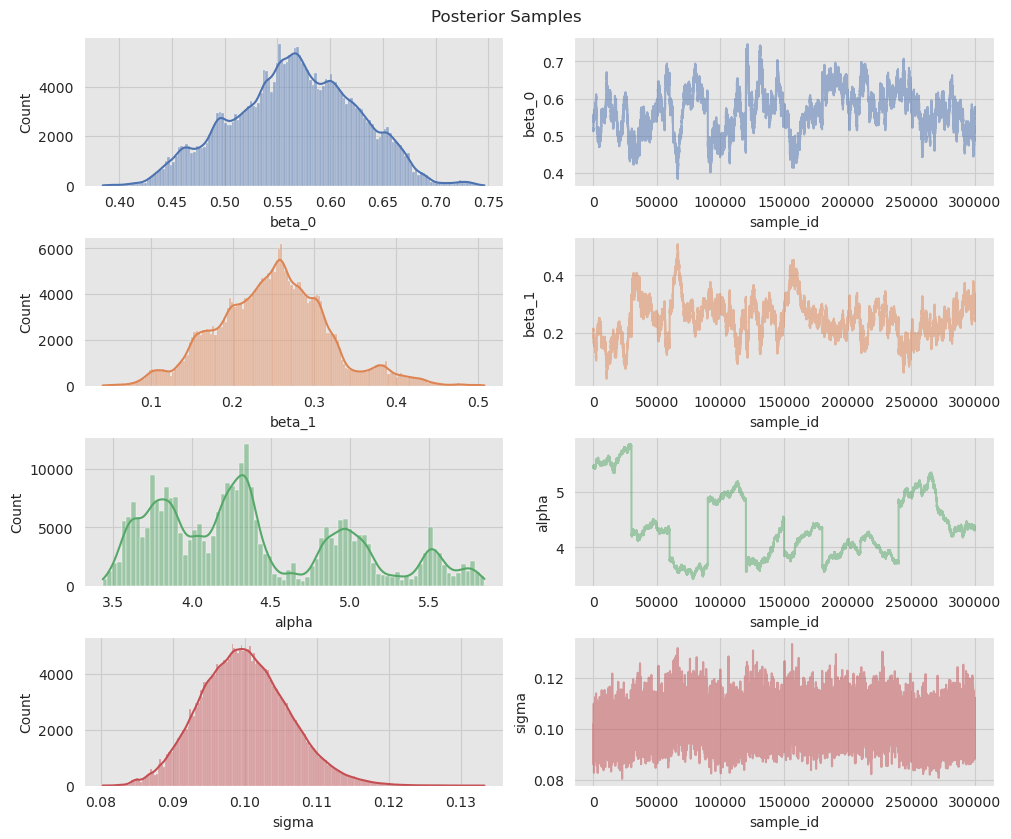

In [13]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, color=sns_c[i], kde=True, ax=axes[i][0])
    sns.lineplot(x='sample_id', y=param, data=chains_df, color=sns_c[i], alpha=0.5, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03);

In [14]:
beta = [0.54, .4] 
alpha, sigma = 2.75, 0.104
beta = [0.57, .26] 
alpha, sigma = 4.2, 0.099

The chains seems to have converged.  (NO, NO, NO!)

### Generate Predictions

#### In-Sample

We want to see the model (in-sample) predictions. We begin by sampling from the distribution mean μ
(that is, we ignore σ).


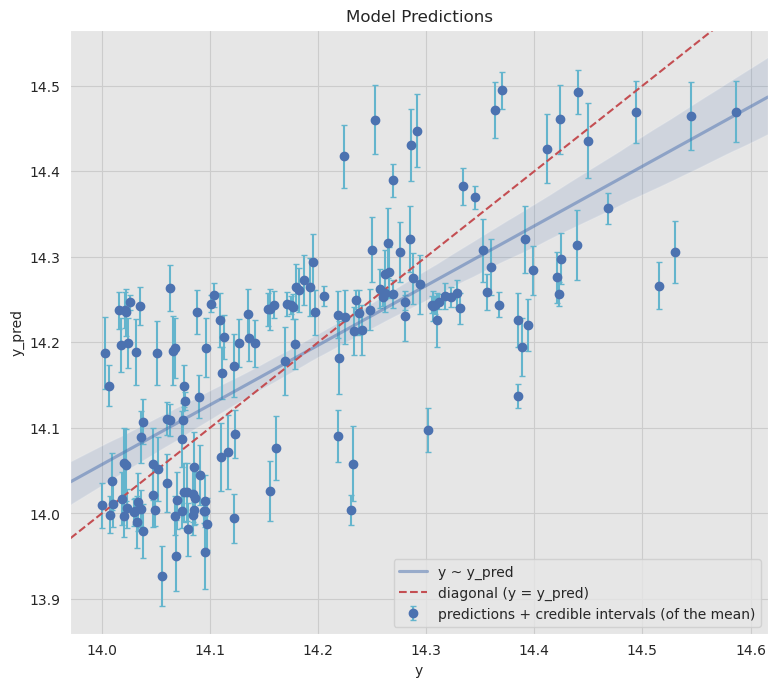

In [15]:
# Here we compute mu = alpha + beta x.
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x.shape[0]))) \
    + tf.linalg.matmul(chains_samples[0], tf.transpose(x)) 

mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
    yerr=1*mu_posterior_std,
    fmt='o',
    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals (of the mean)'
)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Predictions', xlabel='y', ylabel='y_pred');

Now let us generate (in-sample) predictions by sampling from N(μ,σ).


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


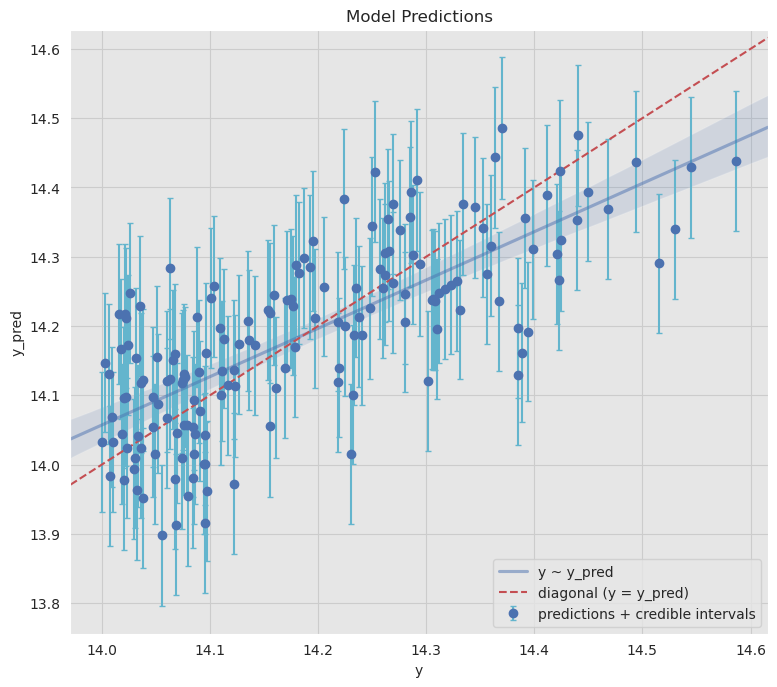

In [16]:
pred_samples = tf.map_fn(
    fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1), 
    elems=tf.transpose(mu_posterior_samples)
)

pred_samples = tf.squeeze(pred_samples)

posterior_mean = tf.math.reduce_mean(pred_samples, axis=1).numpy()
posterior_std = tf.math.reduce_std(pred_samples, axis=1).numpy()

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=posterior_mean, 
    yerr=1*posterior_std,
    fmt='o',
    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals',
)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Predictions', xlabel='y', ylabel='y_pred');

#### Out-Sample

Finally let us generate an out-sample prediction for the vector x^* =(13,12.6).

Again, remember we are not interested in the point prediction but rather on the complete posterior distribution.

In [17]:
x_star = tf.cast([[13.0, 12.6]], dtype)
# Here we compute mu = alpha + beta x.
mu_y_star = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x_star.shape[0]))) \
    + tf.linalg.matmul(chains_samples[0], tf.transpose(x_star)) 
# Compute posterior predictive distribution.
y_star_samples = tf.map_fn(
    fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1), 
    elems=tf.transpose(mu_y_star)
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [18]:
#beta = [0.53, .32] # 
#alpha, sigma = 4., 0.12 # from a step in a chain
# now just after combined chains plot

# Point prediction of the mean.
y_star_true = tf.linalg.matmul(x_star, tf.transpose(tf.cast([beta], dtype))) + alpha
y_star_true  = y_star_true.numpy().flatten()
# Sample from the complete posterior predictive distribution.
y_star_true_samples =tfd.Normal(loc=y_star_true, scale=sigma).sample(num_chains * num_results)
y_star_true_samples = y_star_true_samples.numpy().flatten()
# Mean of the complete posterior predictive distribution.
y_star_true_samples_mean = tf.reduce_mean(y_star_samples, axis=2).numpy().flatten()

beta1: 0.57, beta2: 0.26, alpha: 4.2, sigma: 0.099


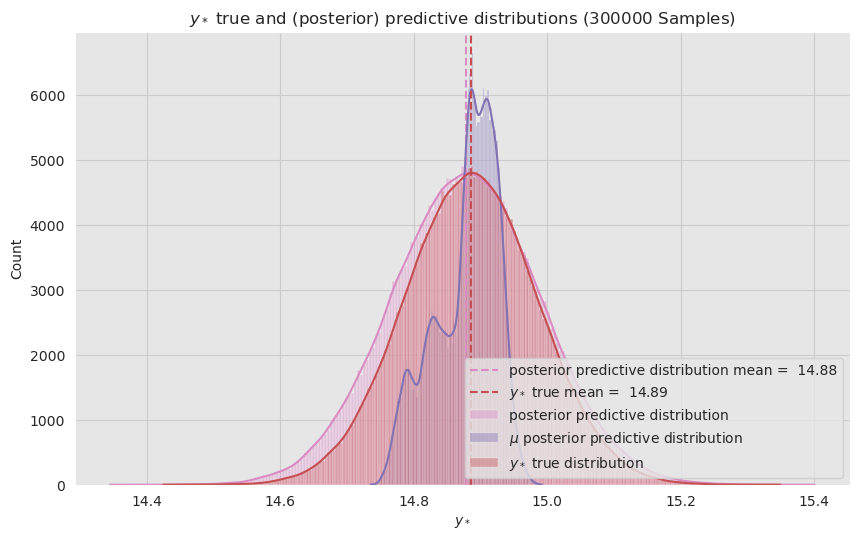

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    x=tf.squeeze(y_star_samples).numpy(), 
    kde=True, 
    color=sns_c[6], 
    alpha=0.4,
    label='posterior predictive distribution', 
    ax=ax
)
ax.axvline(
    x=y_star_true_samples_mean, 
    color=sns_c[6], 
    linestyle='--', 
    label=f'posterior predictive distribution mean = {y_star_true_samples_mean[0]: 0.2f}'
)
sns.histplot(
    x=mu_y_star.numpy().flatten(), 
    kde=True,
    color=sns_c[4], 
    alpha=0.4,
    label='$\mu$ posterior predictive distribution', 
    ax=ax
)
sns.histplot(
    x=y_star_true_samples, 
    kde=True,
    color=sns_c[3], 
    alpha=0.4,
    label='$y_*$ true distribution', 
    ax=ax
)
ax.axvline(
    x=y_star_true, 
    color=sns_c[3], 
    linestyle='--', 
    label=f'$y_*$ true mean = {y_star_true[0]: 0.2f}'
)
#ax.legend(loc='lower left')
ax.legend(loc='lower right')
ax.set(
    title=f'$y_*$ true and (posterior) predictive distributions ({num_chains * num_results} Samples)',
    xlabel=f'$y_*$'
);

print("beta1: {}, beta2: {}, alpha: {}, sigma: {}".format(beta[0], beta[1], alpha, sigma))

- The red distribution is the “true” one which we get by sampling  from the N where parameters alpha, beta are "known"
- The purple distribution is the one of the mean posterior samples, and alpha,beta are samples from the posterior
- The pink distribution is the complete posterior predictive distribution

#### Evaluate the test data

x_m: (163,), y_m: (163,), y_mu: (163,), y_train: (163,), y_test: (95,)

On training data

mu_posterior_std  chi-sq: 19.574
mu posterior delta,scatter: -0.000  0.028

posterior_std     chi-sq: 0.803
posterior delta,scatter:     0.000  0.101



On test data

mu_posterior_std  chi-sq: 80.964
mu posterior delta,scatter:  0.002  0.111

posterior_std     chi-sq: 1.183
posterior delta,scatter:     0.002  0.111



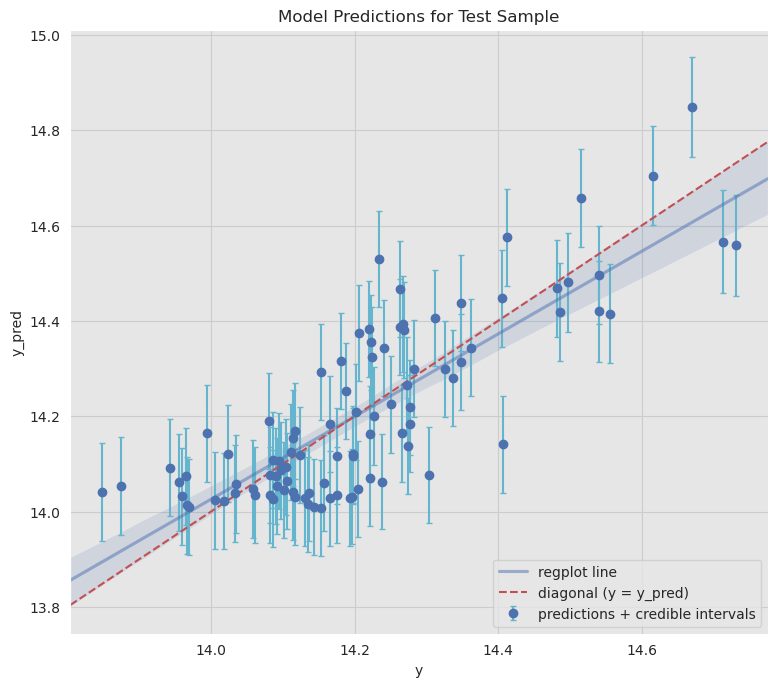

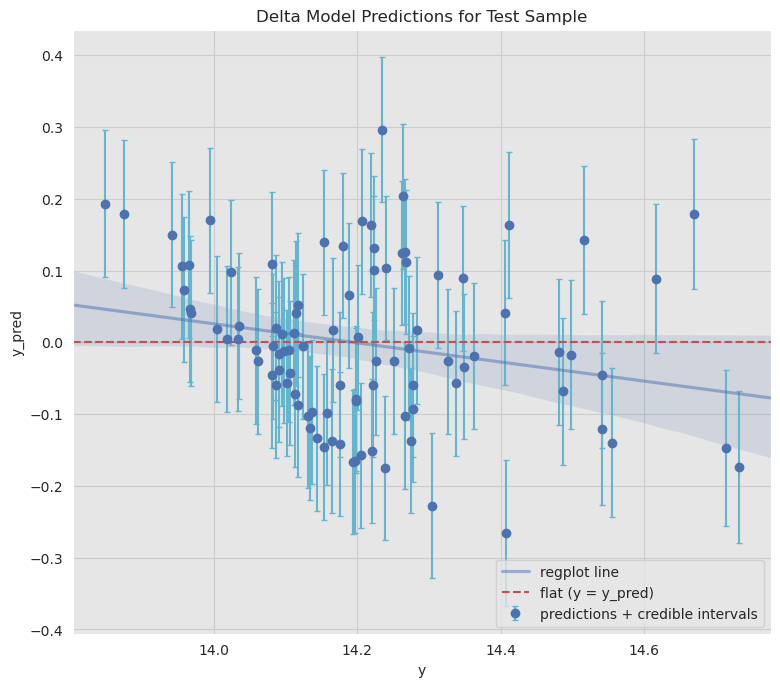

In [20]:
@tf.autograph.experimental.do_not_convert
def eval2 () :
    # Here we compute mu = alpha + beta x.
    mu_posterior_samples = tf.linalg.matmul(
        tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x.shape[0]))) \
        + tf.linalg.matmul(chains_samples[0], tf.transpose(x)) 

    mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
    mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()
    
    pred_samples = tf.map_fn(
        fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1), 
        elems=tf.transpose(mu_posterior_samples)
    )
    pred_samples = tf.squeeze(pred_samples)

    posterior_mean = tf.math.reduce_mean(pred_samples, axis=1).numpy()
    posterior_std = tf.math.reduce_std(pred_samples, axis=1).numpy()

    x_m=tf.squeeze(y).numpy()

    #label='predictions + credible intervals',
    y_m=posterior_mean
    yerr=1*posterior_std

    # label='y ~ y_pred', 
    y_mu     = mu_posterior_mean
    y_mu_std = mu_posterior_std

    print("x_m: {}, y_m: {}, y_mu: {}, y_train: {}, y_test: {}".format(
        x_m.shape, y_m.shape, y_mu.shape, inv_df[yname].shape, y_test.shape))
    
    if (1 == 0) :
        print("\n  i y_train   x_m   y_mu    y_m")
        for i in range(0,y_train.size) :
            print("{:3d} {:6.2f} {:6.2f} {:6.2f} {:6.2f}".format(
            i, inv_df[yname][i], x_m[i]-inv_df[yname][i], y_mu[i]-inv_df[yname][i], y_m[i]-inv_df[yname][i]))
    print("\nOn training data\n")
    print("mu_posterior_std  chi-sq: {:.3f}".format( ((x_m-y_mu)**2/y_mu_std**2).sum()/y_train.size))
    print("mu posterior delta,scatter: {:6.3f} {:6.3f}".format((x_m-y_mu).mean(), mu_posterior_std.mean()))
    print("")
    print("posterior_std     chi-sq: {:.3f}".format( ((x_m-y_m)**2/yerr**2).sum()/y_train.size))
    print("posterior delta,scatter:    {:6.3f} {:6.3f}".format((x_m-y_m).mean(), posterior_std.mean())  )          
    print("")  



# Now lets work y_test
    print("")
    vppd = [];    vmppd = []
    sppd = [];    smppd = []
    vsize = y_test.size
    for i in range(0,vsize) :
        #print (i, X_test[0])
        x_star = tf.cast([X_test[i]], dtype)
    
        # Here we compute mu = alpha + beta x.
        mu_y_star = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x_star.shape[0]))) \
            + tf.linalg.matmul(chains_samples[0], tf.transpose(x_star)) 
    
        # Compute posterior predictive distribution.
        y_star_samples = tf.map_fn(
            fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1), 
            elems=tf.transpose(mu_y_star)
        )

        # label='posterior predictive distribution'
        ppd = tf.squeeze(y_star_samples).numpy()
        vppd.append(ppd.mean())
        sppd.append(ppd.std())
        #print(ppd)
        #print("mean of the posterior predictive distribution: {:.3f}".format(ppd.mean()))


        # label='$\mu$ posterior predictive distribution'
        mppd = mu_y_star.numpy().flatten()
        vmppd.append(mppd.mean())
        smppd.append(mppd.std())
        #print(mppd)
        #print("mean of the $\mu$ posterior predictive distribution: {:.3f}".format(mppd.mean()))

    vppd=np.array(vppd);    vmppd=np.array(vmppd)
    sppd=np.array(sppd);    smppd=np.array(smppd)
    
    ppd_chi = []
    mppd_chi = []
    for i in range(0,vsize) :
        zero = y_test.iloc[i]
        ppd_chi.append((vppd[i]-zero)/sppd[i])
        mppd_chi.append((vmppd[i]-zero)/smppd[i])
    ppd_chi=np.array(ppd_chi)
    mppd_chi=np.array(mppd_chi)
        
    if (1 == 0) :
        for i in range(0,vsize) :
            zero = y_test.iloc[i]
            print("{:3d} {:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}".format(
            i, zero, vppd[i]-zero, vmppd[i]-zero, ppd_chi[i], mppd_chi[i]))
    
    if (1==1) :
        fig, ax = plt.subplots(figsize=(9, 8)) 
        ax.errorbar( x=vppd, y=np.array(y_test), yerr=sppd,
            fmt='o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals',)

        sns.regplot(x=vppd, y = np.array(y_test),
            color=sns_c[0], scatter=False, line_kws=dict(alpha=0.5),  truncate=False,ax=ax,label="regplot line")
        ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
        ax.set(title='Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
        ax.legend(loc='lower right')
        
    if (1==1) :
        fig, ax = plt.subplots(figsize=(9, 8)) 
        ax.errorbar( x=vppd, y=np.array(y_test)-vppd, yerr=sppd,
            fmt='o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals',)

        sns.regplot(x=vppd, y = np.array(y_test)-vppd,
            color=sns_c[0], scatter=False, line_kws=dict(alpha=0.5),  truncate=False,ax=ax,label="regplot line")
        ax.axline(xy1=(14.0,0), slope=0, linestyle='--', color=sns_c[3], label='flat (y = y_pred)')
        ax.set(title='Delta Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
        ax.legend(loc='lower right')
        
    print("\nOn test data\n")
    print("mu_posterior_std  chi-sq: {:.3f}".format( (mppd_chi**2).sum()/vsize))
    print("mu posterior delta,scatter: {:6.3f} {:6.3f}".format((vmppd-y_test).mean(), (vmppd-y_test).std()))
       
    print("")
    print("posterior_std     chi-sq: {:.3f}".format( (ppd_chi**2).sum()/vsize))
    print("posterior delta,scatter:    {:6.3f} {:6.3f}".format((vppd-y_test).mean(), (vppd-y_test).std())  )  
    print("")

eval2()

# 